# Regression Tabular Model for Kaggle Playground Series Season 3 Episode 8 Using Python and XGBoost
### David Lowe
### March 29, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 8 Dataset is a regression modeling situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the Gemstone Price Prediction dataset. Feature distributions are close to but different from the original.

ANALYSIS: The performance of the preliminary XGBoost model achieved an RMSE benchmark of 580. After a series of tuning trials, the final model processed the test dataset with an RMSE score of 584.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 8

Dataset ML Model: Regression with numerical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e8/

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e8/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sun Mar 26 14:34:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import datasets

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBRegressor

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'price'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10

# Set default modeling scoring metric
SCORING_METRIC = 'neg_root_mean_squared_error'

# Define the directory locations and file names
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e08/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e08/test.csv'
ORIGINAL_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e08/cubic_zirconia.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e08/sample_submission.csv'
SUBMISSION_FILE = 'submission_xgboost_'

### 1.c) Load dataset

In [7]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  carat        cut color clarity  depth  table     x     y     z  price
0   0   1.52    Premium     F     VS2   62.2   58.0  7.27  7.33  4.55  13619
1   1   2.03  Very Good     J     SI2   62.0   58.0  8.06  8.12  5.05  13387
2   2   0.70      Ideal     G     VS1   61.2   57.0  5.69  5.73  3.50   2772
3   3   0.32      Ideal     G     VS1   61.6   56.0  4.38  4.41  2.71    666
4   4   1.70    Premium     G     VS2   62.6   59.0  7.65  7.61  4.77  14453


In [8]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [9]:
print(df_dataset_import.describe())

                  id          carat          depth          table  \
count  193573.000000  193573.000000  193573.000000  193573.000000   
mean    96786.000000       0.790688      61.820574      57.227675   
std     55879.856166       0.462688       1.081704       1.918844   
min         0.000000       0.200000      52.100000      49.000000   
25%     48393.000000       0.400000      61.300000      56.000000   
50%     96786.000000       0.700000      61.900000      57.000000   
75%    145179.000000       1.030000      62.400000      58.000000   
max    193572.000000       3.500000      71.600000      79.000000   

                   x              y              z          price  
count  193573.000000  193573.000000  193573.000000  193573.000000  
mean        5.715312       5.720094       3.534246    3969.155414  
std         1.109422       1.102333       0.688922    4034.374138  
min         0.000000       0.000000       0.000000     326.000000  
25%         4.700000       4.710000   

In [10]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [11]:
# Fetch the original dataset and use it to supplement the training
df_dataset_original = pd.read_csv(ORIGINAL_DATASET)
df_dataset_original.drop(columns=['Unnamed: 0'], inplace=True)
df_dataset_original['is_synthetic'] = 0

# Take a peek at the dataframe after import
print(df_dataset_original.head())

   carat        cut color clarity  depth  table     x     y     z  price  \
0   0.30      Ideal     E     SI1   62.1   58.0  4.27  4.29  2.66    499   
1   0.33    Premium     G      IF   60.8   58.0  4.42  4.46  2.70    984   
2   0.90  Very Good     E    VVS2   62.2   60.0  6.04  6.12  3.78   6289   
3   0.42      Ideal     F     VS1   61.6   56.0  4.82  4.80  2.96   1082   
4   0.31      Ideal     F    VVS1   60.4   59.0  4.35  4.43  2.65    779   

   is_synthetic  
0             0  
1             0  
2             0  
3             0  
4             0  


In [12]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import['is_synthetic'] = 1
df_dataset_import.drop(columns=['id'], inplace=True)
df_dataset_import = pd.concat([df_dataset_import, df_dataset_original],
                              ignore_index=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220540 entries, 0 to 220539
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   carat         220540 non-null  float64
 1   cut           220540 non-null  object 
 2   color         220540 non-null  object 
 3   clarity       220540 non-null  object 
 4   depth         219843 non-null  float64
 5   table         220540 non-null  float64
 6   x             220540 non-null  float64
 7   y             220540 non-null  float64
 8   z             220540 non-null  float64
 9   price         220540 non-null  int64  
 10  is_synthetic  220540 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 18.5+ MB


In [13]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

   carat        cut color clarity  depth  table     x     y     z  target  \
0   1.52    Premium     F     VS2   62.2   58.0  7.27  7.33  4.55   13619   
1   2.03  Very Good     J     SI2   62.0   58.0  8.06  8.12  5.05   13387   
2   0.70      Ideal     G     VS1   61.2   57.0  5.69  5.73  3.50    2772   
3   0.32      Ideal     G     VS1   61.6   56.0  4.38  4.41  2.71     666   
4   1.70    Premium     G     VS2   62.6   59.0  7.65  7.61  4.77   14453   

   is_synthetic  
0             1  
1             1  
2             1  
3             1  
4             1  
        carat        cut color clarity  depth  table     x     y     z  \
220535   1.11    Premium     G     SI1   62.3   58.0  6.61  6.52  4.09   
220536   0.33      Ideal     H      IF   61.9   55.0  4.44  4.42  2.74   
220537   0.51    Premium     E     VS2   61.7   58.0  5.12  5.15  3.17   
220538   0.27  Very Good     F    VVS2   61.8   56.0  4.19  4.20  2.60   
220539   1.25    Premium     J     SI1   62.0   58.0  6.90 

In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220540 entries, 0 to 220539
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   carat         220540 non-null  float64
 1   cut           220540 non-null  object 
 2   color         220540 non-null  object 
 3   clarity       220540 non-null  object 
 4   depth         219843 non-null  float64
 5   table         220540 non-null  float64
 6   x             220540 non-null  float64
 7   y             220540 non-null  float64
 8   z             220540 non-null  float64
 9   target        220540 non-null  int64  
 10  is_synthetic  220540 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 18.5+ MB


In [15]:
print(df_dataset_import.describe())

               carat          depth          table              x  \
count  220540.000000  219843.000000  220540.000000  220540.000000   
mean        0.791628      61.811561      57.255604       5.717090   
std         0.464561       1.126671       1.961255       1.111782   
min         0.200000      50.800000      49.000000       0.000000   
25%         0.400000      61.200000      56.000000       4.700000   
50%         0.700000      61.900000      57.000000       5.700000   
75%         1.030000      62.400000      58.000000       6.520000   
max         4.500000      73.600000      79.000000      10.230000   

                   y              z         target   is_synthetic  
count  220540.000000  220540.000000  220540.000000  220540.000000  
mean        5.721742       3.534712    3965.531450       0.877723  
std         1.110328       0.692876    4033.215125       0.327606  
min         0.000000       0.000000     326.000000       0.000000  
25%         4.710000       2.900000   

In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

carat             0
cut               0
color             0
clarity           0
depth           697
table             0
x                 0
y                 0
z                 0
target            0
is_synthetic      0
dtype: int64
Total number of NaN in the dataframe:  697


### 1.e) Splitting Data into Sets

In [17]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (220540, 11) df_features_train.shape: (220540, 10) df_target_train.shape: (220540,)


### 1.f) Set up the parameters for data visualization

In [18]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

## Task 2 - Summarize and Visualize Data

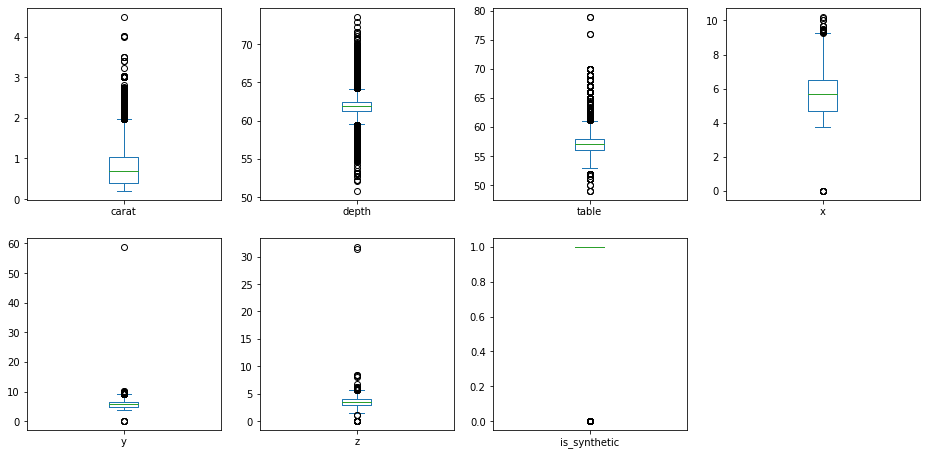

In [19]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

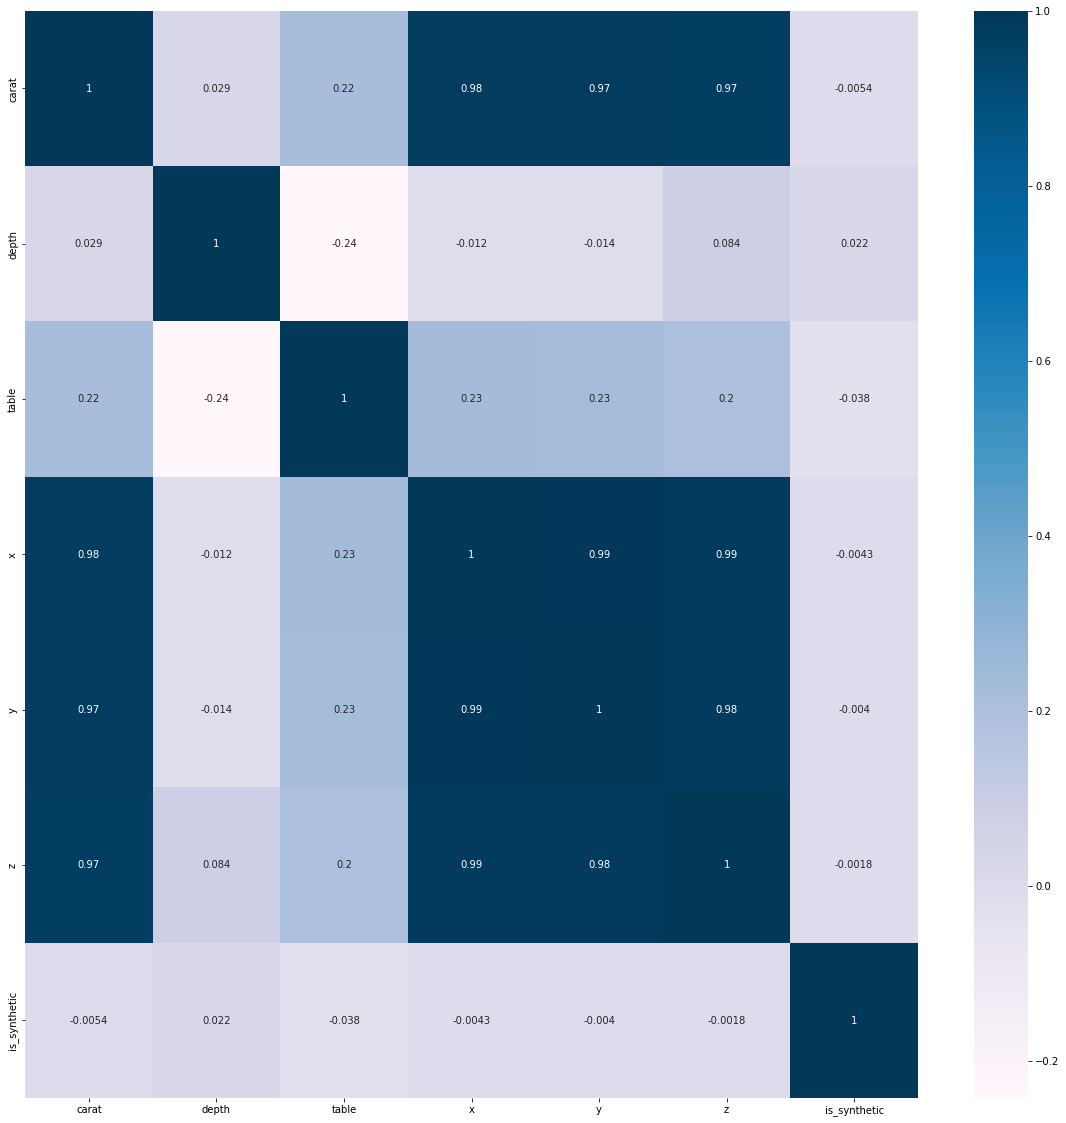

In [20]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

## Task 3 - Pre-process Data

### 3.a) Feature Scaling

In [21]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 7
Number of categorical columns: 3
Total number of columns in the feature dataframe: 10


In [22]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
    ], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Transformed features from df_features_train.shape: (220540, 10) to array_features_train.shape: (220540, 27)


### 3.b) Training Data Balancing

In [23]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [24]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [25]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
array_target_train = df_target_train.to_numpy()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (220540, 27) array_target_train.shape: (220540,)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Task 4 - Train and Tune Models

### 4.a) Set test options and evaluation metric

In [26]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [27]:
train_models.append(('XGB', XGBRegressor(random_state=RNG_SEED, n_jobs=N_JOBS, objective='reg:squarederror', tree_method='gpu_hist')))

In [28]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


XGB: -580.702924 (14.800091)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=2, num_parallel_tree=None, predictor=None,
             random_state=888, ...)
Model training time: 0:00:09.341550 

Average metrics (neg_root_mean_squared_error) from all models: -580.7029235694569
Total training time for all models: 0:00:09.358068


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    9.2s finished


### 4.b) Algorithm Tuning

In [29]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [30]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBRegressor(random_state=RNG_SEED, n_jobs=N_JOBS, objective='reg:squarederror', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 45 candidates, totalling 450 fits
Best: -580.285485 using {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100}
-619.713212 (13.553208) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
-597.415702 (13.273680) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
-590.495789 (12.980989) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
-586.515552 (12.928856) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
-584.146872 (12.737934) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
-619.794519 (11.783846) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
-596.229363 (12.612082) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
-588.948209 (13.061910) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
-585.202189 (13.221633) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
-583.245251 (12.970820) with: {'m

In [31]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 6
Best min_child_weight parameter: 2
Best n_estimators parameter: 100


In [32]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBRegressor(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='reg:squarederror', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best: -580.285485 using {'colsample_bytree': 1.0, 'subsample': 1.0}
-588.177440 (12.260642) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
-584.551306 (14.247749) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
-582.346029 (13.841043) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
-581.522257 (13.847988) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
-588.765103 (12.799955) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
-585.956761 (13.928584) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
-583.001137 (12.723078) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
-581.420432 (14.206059) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
-588.880304 (13.510055) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
-585.763381 (12.566394) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
-583.973383 (12.874453) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
-580.827898 (14.023416) with: {'colsample_bytree': 0.9,

In [33]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 1.0
Best subsample parameter: 1.0


### 4.c) Compare Algorithms After Tuning

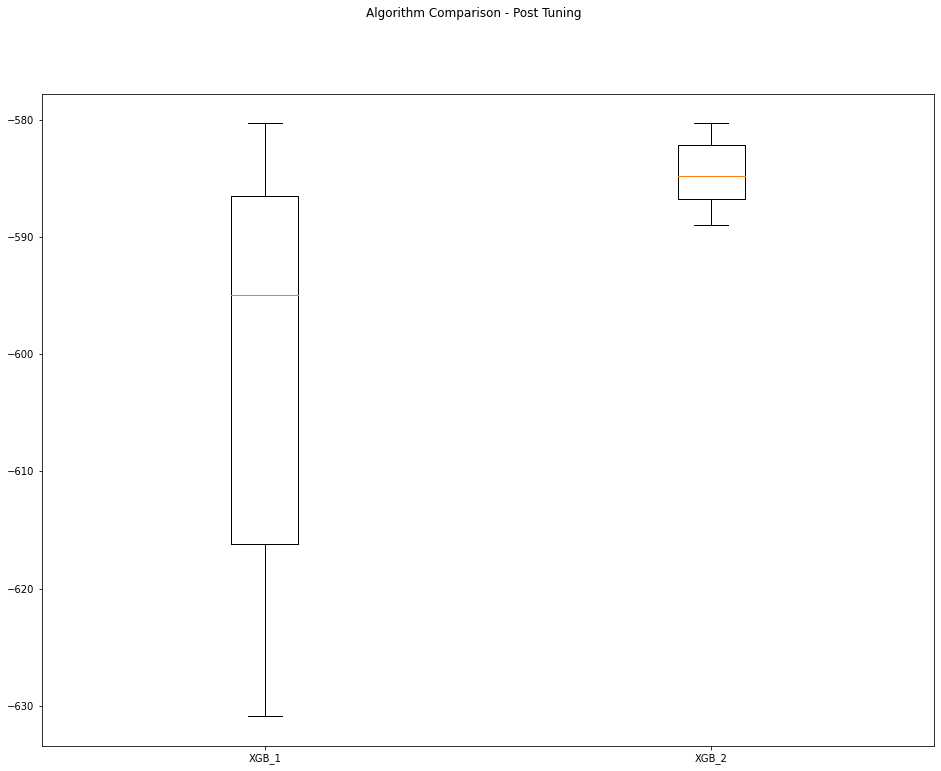

In [34]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Task 5 - Finalize Model and Make Predictions

### 5.a) Train the Final Model

In [35]:
final_model = XGBRegressor(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                           colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE, random_state=RNG_SEED,
                           n_jobs=N_JOBS, objective='reg:squarederror', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=2, num_parallel_tree=None, predictor=None,
             random_state=888, ...)


### 5.b) Load Test Dataset and Make Predictions

In [36]:
df_features_test = pd.read_csv(TEST_DATASET)
df_features_test['is_synthetic'] = 1

# Take a peek at the dataframe after import
print(df_features_test.head())

       id  carat        cut color clarity  depth  table     x     y     z  \
0  193573   0.35      Ideal     D     VS2   62.3   56.0  4.51  4.54  2.82   
1  193574   0.77  Very Good     F     SI2   62.8   56.0  5.83  5.87  3.68   
2  193575   0.71      Ideal     I     VS2   61.9   53.0  5.77  5.74  3.55   
3  193576   0.33      Ideal     G    VVS2   61.6   55.0  4.44  4.42  2.73   
4  193577   1.20  Very Good     I     VS2   62.7   56.0  6.75  6.79  4.24   

   is_synthetic  
0             1  
1             1  
2             1  
3             1  
4             1  


In [37]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

       id
0  193573
1  193574
2  193575
3  193576
4  193577


In [38]:
# Take a peek at the dataframe after cleaning
print(df_features_test.head())

       id  carat        cut color clarity  depth  table     x     y     z  \
0  193573   0.35      Ideal     D     VS2   62.3   56.0  4.51  4.54  2.82   
1  193574   0.77  Very Good     F     SI2   62.8   56.0  5.83  5.87  3.68   
2  193575   0.71      Ideal     I     VS2   61.9   53.0  5.77  5.74  3.55   
3  193576   0.33      Ideal     G    VVS2   61.6   55.0  4.44  4.42  2.73   
4  193577   1.20  Very Good     I     VS2   62.7   56.0  6.75  6.79  4.24   

   is_synthetic  
0             1  
1             1  
2             1  
3             1  
4             1  


In [39]:
print(df_features_test.describe())

                  id          carat          depth          table  \
count  129050.000000  129050.000000  129050.000000  129050.000000   
mean   258097.500000       0.789256      61.820522      57.239608   
std     37253.670457       0.462502       1.080249       1.918908   
min    193573.000000       0.200000      53.200000      51.000000   
25%    225835.250000       0.400000      61.300000      56.000000   
50%    258097.500000       0.700000      61.900000      57.000000   
75%    290359.750000       1.030000      62.400000      58.000000   
max    322622.000000       4.500000      70.600000      70.000000   

                   x              y              z  is_synthetic  
count  129050.000000  129050.000000  129050.000000      129050.0  
mean        5.711767       5.716336       3.531802           1.0  
std         1.109666       1.102485       0.690749           0.0  
min         0.000000       0.000000       0.000000           1.0  
25%         4.700000       4.710000       2

In [40]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (129050, 11) to array_features_test.shape: (129050, 27)


In [41]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[ 844.3414 2562.5776 2314.7378 ... 7659.996  5377.059  4256.135 ]


In [42]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

price


In [43]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

       id        price
0  193573   844.341370
1  193574  2562.577637
2  193575  2314.737793
3  193576   843.742554
4  193577  5581.146484


In [44]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_xgboost_20230326-1453.csv


In [45]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:19:16.267512
